In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from local_paths import analysis_dir, annot_path
from storage import get_storage_functions
from hier_group import unpack_hier_names, annot_names, hier_lookup
import crossing_point

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'

#============================================================================
# config
#============================================================================
rising_cond = 'self_consistency/current'
falling_cond = 'self_consistency/previous'
clearance_thres = 100

#============================================================================
# paths
#============================================================================
rsc_dir = analysis_dir + 'self_consistency'
output_dir = rsc_dir + '-cp'

In [3]:
# Parameters
sess_name = "Pa210201"
rsc_dir = "../test_results/hier_group"
output_dir = "../test_results/hier_group"


# Check prereqs and params

In [4]:
rsc_path = Path(rsc_dir) / (sess_name + '.h5')
print('Loading return-fixation self-consistency results from', rsc_path)
rsc_path = rsc_path.expanduser()
assert rsc_path.is_file()

print('Using recording location annotations at', annot_path)
annot_path = Path(annot_path).expanduser()
assert annot_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading return-fixation self-consistency results from ../test_results/hier_group/Pa210201.h5
Using recording location annotations at ../db/bank_array_regions.csv
Saving results to ../test_results/hier_group/Pa210201.h5


In [5]:
analysis_name = 'crossing_point'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [6]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [7]:
group = analysis_name + '/config/'
save_results(group+'rising_cond', rising_cond)
save_results(group+'falling_cond', falling_cond)
save_results(group+'clearance_thres', clearance_thres, attrs=dict(unit='ms'))

# Tally units and levels

In [8]:
adf = pd.read_csv(annot_path).set_index('Session').loc[[sess_name]].set_index('Bank')

In [9]:
rising_ds = xr.load_dataset(rsc_path, group=rising_cond)
falling_ds = xr.load_dataset(rsc_path, group=falling_cond)

In [10]:
names = rising_ds['unit'].values
assert np.array_equal(names, falling_ds['unit'].values.astype(str))
hier_names = unpack_hier_names(names)

with h5.File(rsc_path, 'r') as f:
    dset = f['self_consistency/unit_names']
    all_groups_name = dset.attrs['all_groups_name'].astype(str)
    all_groups_uid = dset.attrs['all_groups_uid']
m_unit = hier_names[:,0] == 'Unit'
n_unit = m_unit.sum()
all_groups_idx = all_groups_uid + n_unit
all_hier_names = np.concatenate([hier_names[m_unit], unpack_hier_names(all_groups_name)])

In [11]:
unit_df = annot_names(
    np.concatenate([names[(hier_names[:,0] == 'Unit')], all_groups_name]),
    adf)

m = unit_df['Level'] == 'Unit'
unit_df['Index'] = -1
unit_df.loc[m,'Index'] = unit_df.index[m].astype(int)
unit_df.loc[~m,'Index'] = all_groups_idx

assert unit_df['Index'].min() == 0 and unit_df['Index'].max() == len(names)-1
unit_df['Name'] = all_hier_names[:,1]
unit_df

,Unit,Channel,Bank,Array ID,Level,Index,Name
0,Unit/1,1,0,1,Unit,0,1
1,Unit/2,2,0,1,Unit,1,2
2,Unit/3,3,0,1,Unit,2,3
3,Unit/4,4,0,1,Unit,3,4
4,Unit/4a,4,0,1,Unit,4,4a
...,...,...,...,...,...,...,...
103,Channel/55,55,1,2,Channel,103,55
104,Bank/0,-1,0,1,Bank,104,0
105,Bank/1,-1,1,2,Bank,105,1
106,Array/1,-1,-1,-1,Array,104,1


# Main

In [12]:
hiers = ['Unit', 'Channel', 'Bank', 'Array']
ts = rising_ds['time'].values
y0s_all = np.concatenate([
    falling_ds['sample'].values[None,...],  # shape (1n_t, n_neur)
    falling_ds['bootstraps'].values])       # shape (n_boot, n_t, n_neur)
y1s_all = np.concatenate([
    rising_ds['sample'].values[None,...],   # shape (1n_t, n_neur)
    rising_ds['bootstraps'].values])        # shape (n_boot, n_t, n_neur)
y0s_all = np.ma.masked_invalid(y0s_all)
y1s_all = np.ma.masked_invalid(y1s_all)

n_boot = y1s_all.shape[0] - 1
n_neur = y1s_all.shape[-1]
cps, cls = (np.empty((n_boot+1, n_neur), dtype=np.float32) for i in range(2))
pks, tps = (np.empty((2, n_boot+1, n_neur), dtype=np.float32) for i in range(2))

last_cp_df = None
done_idc = set()
for level in hiers[::-1]:
    unit_df_ = unit_df[unit_df['Level'] == level]
    if not len(unit_df_): continue

    ih = hiers.index(level)
    cp_df = {
        k: np.zeros(len(unit_df_)) for k in
        [f'Latency_{j}' for j in range(n_boot+1)]
        + [f'Clearance_{j}' for j in range(n_boot+1)]}

    for ii, (_, row) in enumerate(tqdm(unit_df_.iterrows(), total=len(unit_df_), desc=level)):
        name = row['Unit']
        i = row['Index']
        if i in done_idc:
            continue
        for j in range(n_boot+1):
            hcp = 0
            if last_cp_df is not None:
                hcp_ = hier_lookup(np.array([name]), adf, last_cp_df, hiers=hiers[ih+1:])
                if len(hcp_):
                    assert len(hcp_) < 2
                    if hcp_[f'Clearance_{j}'] >= clearance_thres:
                        hcp = hcp_[f'Latency_{j}']

            cps[j,i], cls[j,i] = cp, cl = \
                crossing_point.get_central_crossing_point_and_clearance(
                    ts, y0s_all[j,:,i], y1s_all[j,:,i], x_cent=hcp, direction='up')[:2]
            cp_df[f'Latency_{j}'][ii] = cp
            cp_df[f'Clearance_{j}'][ii] = cl

            for k, ys in enumerate((y0s_all[j,:,i], y1s_all[j,:,i])):
                ys = np.array(ys)  # convert possibly masked array to array
                if ~np.isfinite(ys).any():
                    pks[k,j,i] = tps[k,j,i] = np.nan
                    continue
                l = np.nanargmax(ys)
                if np.isnan(ys[l]):
                    pks[k,j,i] = tps[k,j,i] = np.nan
                else:
                    pks[k,j,i] = ys[l]
                    tps[k,j,i] = ts[l]
        done_idc.add(i)

    df_ = unit_df_.copy()
    df_ = pd.concat([df_, pd.DataFrame(cp_df, index=df_.index)], axis=1)
    if last_cp_df is None:
        last_cp_df = df_
    else:
        last_cp_df = pd.concat([df_, last_cp_df])

Array: 100%|██████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]

Bank: 100%|█████████████████████████████████████| 2/2 [00:00<00:00, 6996.34it/s]

Channel: 100%|██████████████████████████████████| 12/12 [00:12<00:00,  1.01s/it]

Unit: 100%|█████████████████████████████████████| 92/92 [01:07<00:00,  1.37it/s]

In [13]:
with h5.File(rsc_path, 'r') as f:
    sdf_suffix = f['self_consistency/config/sdf_suffix'][()].decode()
    t_step = f['self_consistency/config/time_windows/t_step'][()]
sdf_suffix, t_step

('-mwa_50-hg', 10)

In [14]:
cps, cls, pks, tps = map(np.ma.masked_invalid, (cps, cls, pks, tps))
df = {}

df['Latency'] = cps[0].filled(np.nan)
df['Clearance'] = cls[0].filled(np.nan)

df['Boots. bias, train'] = (cps[0] - cps[1::2].mean(0)).filled(np.nan)
df['Boots. stdev., train'] = cps[1::2].std(0).filled(np.nan)
df['Boots. mean clearance, train'] = cls[1::2].mean(0).filled(0)
df['Boots. frac., train'] = 1 - cls[1::2].mask.mean(0)
df['Boots. bias'] = (cps[0] - cps[2::2].mean(0)).filled(np.nan)
df['Boots. stdev.'] = cps[2::2].std(0).filled(np.nan)
df['Boots. mean clearance'] = cls[2::2].mean(0).filled(0)
df['Boots. frac.'] = 1 - cls[2::2].mask.mean(0)

for i, (pks_, tps_) in enumerate(zip(pks, tps)):
    df[f'Peak {i} SC'] = pks_[0].filled(np.nan)
    df[f'Peak {i} time'] = tps_[0].filled(np.nan)
    df[f'Boots. mean peak {i} SC, train'] = pks_[1::2].mean(0).filled(np.nan)
    df[f'Boots. stdev. peak {i} SC, train'] = pks_[1::2].std(0).filled(np.nan)
    df[f'Boots. mean peak {i} time, train'] = tps_[1::2].mean(0).filled(np.nan)
    df[f'Boots. stdev. peak {i} time, train'] = tps_[1::2].std(0).filled(np.nan)
    df[f'Boots. mean peak {i} SC'] = pks_[2::2].mean(0).filled(np.nan)
    df[f'Boots. stdev. peak {i} SC'] = pks_[2::2].std(0).filled(np.nan)
    df[f'Boots. mean peak {i} time'] = tps_[2::2].mean(0).filled(np.nan)
    df[f'Boots. stdev. peak {i} time'] = tps_[2::2].std(0).filled(np.nan)

df = pd.DataFrame(df)
df = df.iloc[unit_df['Index'].values].reset_index().drop(columns='index')
df[['Level','Name']] = unit_df[['Level', 'Name']].values
df['Session'] = sess_name
df['SDF suffix'] = sdf_suffix
df['T step'] = t_step
df.head()

,Latency,Clearance,"Boots. bias, train","Boots. stdev., train","Boots. mean clearance, train","Boots. frac., train",Boots. bias,Boots. stdev.,Boots. mean clearance,Boots. frac.,...,"Boots. stdev. peak 1 time, train",Boots. mean peak 1 SC,Boots. stdev. peak 1 SC,Boots. mean peak 1 time,Boots. stdev. peak 1 time,Level,Name,Session,SDF suffix,T step
0,67.886597,85.876289,53.623008,38.720665,58.639502,1.0,60.930965,42.985992,58.175859,1.0,...,210.226996,0.166094,0.039931,-7.8,214.625628,Unit,1,Pa210201,-mwa_50-hg,10
1,3.992806,71.207191,-18.090190,33.605727,103.278164,1.0,-15.815748,31.320628,98.318770,1.0,...,24.151812,0.321543,0.048817,147.1,22.684576,Unit,2,Pa210201,-mwa_50-hg,10
2,1.534653,24.308720,-3.871206,21.253003,49.296064,1.0,-3.515214,21.184511,52.725977,1.0,...,241.867236,0.156934,0.031051,21.2,240.747918,Unit,3,Pa210201,-mwa_50-hg,10
3,-22.297297,74.271332,-12.371245,23.119840,71.866768,1.0,-10.437323,28.374904,71.102207,1.0,...,142.883554,0.360127,0.098525,89.9,146.884274,Unit,4,Pa210201,-mwa_50-hg,10
4,89.431816,235.080383,45.506372,60.809461,115.407686,1.0,48.280771,56.520708,113.334951,1.0,...,67.751310,0.275820,0.028857,242.2,23.327237,Unit,4a,Pa210201,-mwa_50-hg,10


In [15]:
df.to_hdf(
    output_path, analysis_name+'/latency_dataframe',
    mode='a', format='table', complevel=9, complib='zlib')

# Wrap up

In [16]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [17]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-19T22:04:23.396254-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

xarray: 2023.4.2
pandas: 2.0.1
h5py  : 3.8.0
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy : 1.24.3



# Basic visualization of results

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

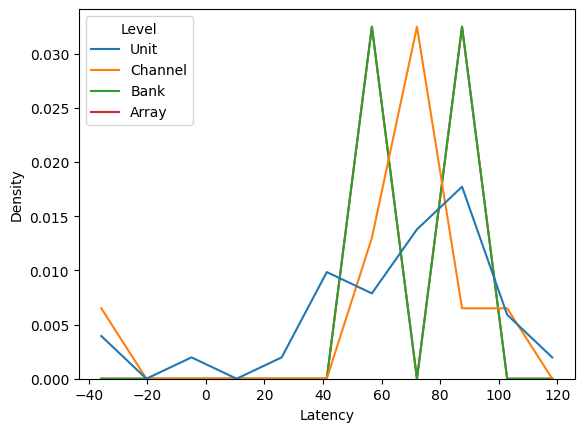

In [19]:
sns.histplot(data=df[df['Clearance']>=clearance_thres], x='Latency', hue='Level', element='poly', fill=False, stat='density', common_norm=False);

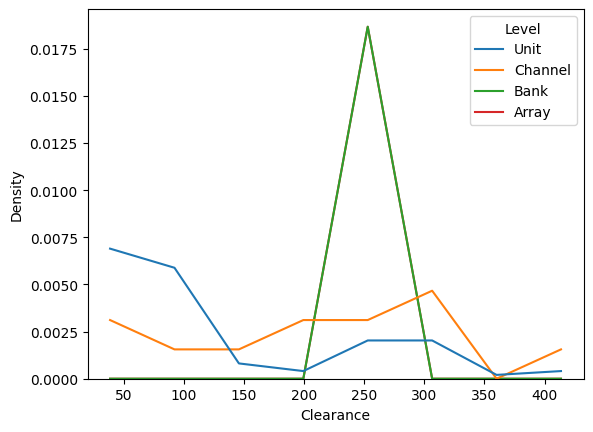

In [20]:
sns.histplot(data=df, x='Clearance', hue='Level', element='poly', fill=False, stat='density', common_norm=False);

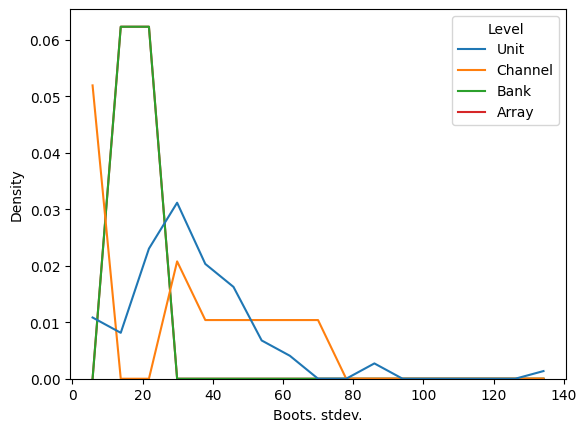

In [21]:
sns.histplot(data=df, x='Boots. stdev.', hue='Level', element='poly', fill=False, stat='density', common_norm=False);